In [ ]:
## Classifier - main driver for neuron - Eric Buehler 2022

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
prefix='/content/drive/MyDrive/Colab Notebooks/neuron-v4'
prefix_='/content/drive/MyDrive/"Colab Notebooks"/neuron-v4'
modelname="4_24_22_m2"

prefix_models=prefix+"/models/"+modelname+"/"
prefix_images=prefix+"/images/"+modelname+"/"



if not os.path.exists(prefix_models):
    os.makedirs(prefix_models)

if not os.path.exists(prefix_images):
    os.makedirs(prefix_images)
            
os.chdir(prefix)

Mounted at /content/drive


In [ ]:
import os,sys
import math
import matplotlib.pyplot as plt

import numpy as np
import cv2
import PIL 
from PIL import Image, ImageOps

import pickle
import tqdm


In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-36a3153e-4404-68f5-3370-b51a0cb2ad80)


In [ ]:
!nvidia-smi 

Mon Apr 25 00:54:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
 
import torchvision
 
import matplotlib.pyplot as plt
import numpy as np
 
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR, StepLR, LambdaLR

print("Torch version:", torch.__version__) 

Torch version: 1.10.0+cu111


In [ ]:
!git clone https://github.com/lucidrains/perceiver-pytorch
!cd perceiver-pytorch/
!pip install perceiver-pytorch

fatal: destination path 'perceiver-pytorch' already exists and is not an empty directory.


In [ ]:
import torch
from perceiver_pytorch import Perceiver
from perceiver_pytorch import PerceiverIO
 
from torch.utils.data import DataLoader,Dataset
from torchvision.io import read_image
import pandas as pd
from sklearn.model_selection import train_test_split

from PIL import Image

to_pil = transforms.ToPILImage()

In [ ]:
from torch.autograd import Variable

In [ ]:
numchannel=3
batchSize=8
CPUonly=False

In [ ]:
class ImageDataset(Dataset):
    def __init__(self,dir,mode,images,transform):
        self.images=list(images)
        self.mode=list(mode["Mode"])
        self.speed=list(mode["Speed"])
        self.transform=transform
        self.dir=dir+"/images/image_"
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self,index):
        im_pil = Image.open(self.dir+str(int(self.images[index]))+".png").convert('RGB')#.convert("L")

        image=self.transform(im_pil)

        return (self.mode[index],image)

In [ ]:
"""
Left=1
Right=2
Fwd=3
Bwd=4
Stop=0
"""

'\nLeft=1\nRight=2\nFwd=3\nBwd=4\nStop=0\n'

In [ ]:
import torchvision.transforms as T

# Dataset loader
data_dir = './data_v4'

def load_split_train_test(data_dir,csvfile, valid_size = .2):
    train_transforms = transforms.Compose([
                                     transforms.Resize((80,160)),
                                       transforms.ToTensor()
                                       ])
    test_transforms = transforms.Compose([
                                         transforms.Resize((80,160)),
                                       transforms.ToTensor()
                                       ])

    df=pd.read_csv(csvfile)
    mode=df.iloc[:,1:]
    images=df.iloc[:,0]
    X_train, X_test, y_train, y_test =train_test_split(mode,images,test_size=valid_size)#, shuffle=False) #No shuffle because of memory
    train_data=ImageDataset(data_dir,X_train,y_train,train_transforms)
    test_data=ImageDataset(data_dir,X_test,y_test,test_transforms)
    trainloader = torch.utils.data.DataLoader(train_data, batch_size=batchSize)

    testloader = torch.utils.data.DataLoader(test_data, batch_size=1)
    return trainloader, testloader

csvfile=data_dir+"/train.csv"
dataloader, testloader = load_split_train_test(data_dir,csvfile, .5)
print("Number of training batches: ", len(dataloader), "batch size= ", batchSize, "total: ",len(dataloader)*batchSize)
print("Number of test batches: ", len(testloader), "batch size= ", 1, "total: ",len(testloader))

print("TOTAL images (account for full batches): ", len(dataloader)*batchSize+len(testloader) )

Number of training batches:  200 batch size=  8 total:  1600
Number of test batches:  1600 batch size=  1 total:  1600
TOTAL images (account for full batches):  3200


In [ ]:
print(len(dataloader))
print(len(dataloader)*batchSize)

200
1600


(160, 80)


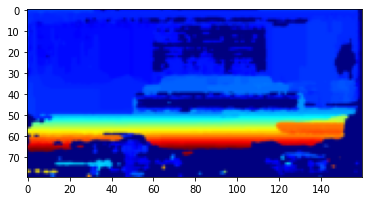

In [ ]:
input=next(iter(testloader))[1]
image = to_pil(input[0])
print(image.size)
plt.imshow(image)
plt.show()

In [ ]:
im_resx=image.size[0]
im_resy=image.size[1]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")

if CPUonly == True:
     device = torch.device("cpu")
     print("CPU")

In [ ]:
from torch.nn.modules.dropout import Dropout2d


class network(nn.Module):
    def __init__(self,nclasses):
        super(network, self).__init__()
        self.queries_dim_=256
        latent_dim_=784
        logits_dim= nclasses
        embed_dim=128
        embed_dim_min=16
        dim=3
        self.embed_dim_=embed_dim

        self.convert_up = nn.Sequential( #numchannel -> embed_dim
            nn.Linear(  numchannel, 4),
            nn.Linear(  4, 8),
            nn.Linear(  8, 16),
            nn.Linear(  16, 32),
            nn.Linear(  32, 48),
            nn.Linear(  48, embed_dim)
        )

        self.encoders=[]
        embed_dim_=embed_dim
        while embed_dim_>embed_dim_min:
            layer=nn.Conv2d(in_channels=embed_dim_, out_channels=int(embed_dim_/2), kernel_size=3, stride=1, padding=1).to(device)
            self.encoders.append(layer)
            embed_dim_=int(embed_dim_/2)

        self.decoders=[]
        embed_dim_=embed_dim_min
        while embed_dim_<embed_dim:
            layer=nn.Conv2d(in_channels=embed_dim_, out_channels=int(embed_dim_*2), kernel_size=3, stride=1, padding=1).to(device)
            self.decoders.append(layer)
            embed_dim_=int(embed_dim_*2)
            
        self.convs=[]
        for item in self.encoders:
            self.convs.append(item)
        self.convs.append(nn.BatchNorm2d(embed_dim_min))
        for item in self.decoders:
            self.convs.append(item)
        self.convs.append(nn.BatchNorm2d(embed_dim))
        self.convs=nn.ModuleList(self.convs)

        self.query_gen = nn.Sequential( # embed_dim*4 -> self.queries_dim_
            nn.Linear(  embed_dim*4, 384),
            nn.Linear(  384, 512),
            nn.Linear(  512, 640),
            nn.Linear(  640, 784),
            nn.Linear(  784, 1024),
            nn.Linear(  1024, 784),
            nn.Linear(  784, 640),
            nn.Linear(  640, 512),
            nn.Linear(  512, self.queries_dim_),
        )
        
        self.convert_down = nn.Sequential( #im_resx*im_resy -> 1
            nn.Linear(  im_resx*im_resy, 2048),
            nn.Linear(  2048, 1024),
            nn.Linear(  1024, 784),
            nn.Linear(  784, 512),
            nn.Linear(  512, 256),
            nn.Linear(  256, 128),
            nn.Linear(  128, 1),
        )

        self.pos_emb_x = nn.Embedding(im_resy, embed_dim*1)
        self.pos_emb_y = nn.Embedding(im_resx, embed_dim*1)

        self.pos_matrix_i = torch.zeros (im_resx, im_resy, dtype=torch.long)
        self.pos_matrix_j = torch.zeros (im_resx, im_resy,dtype=torch.long)
        for i in range(im_resy):
            for j in range(im_resx):
                self.pos_matrix_i [j,i]=i
                self.pos_matrix_j [j,i]=j
                       
        self.pos_matrix_j =torch.flatten(self.pos_matrix_j , start_dim=0, end_dim=1) 
        self.pos_matrix_i =torch.flatten(self.pos_matrix_i , start_dim=0, end_dim=1)  

        self.model = PerceiverIO(
            dim = embed_dim*4,                    # dimension of sequence to be encoded
            queries_dim = self.queries_dim_,            # dimension of decoder queries
            logits_dim = nclasses,            # dimension of final logits
            depth = 12,                   # depth of net
            num_latents = 512,           # number of latents, or induced set points, or centroids. different papers giving it different names
            latent_dim = latent_dim_,            # latent dimension
            cross_heads = 1,             # number of heads for cross attention. paper said 1
            latent_heads = 8,            # number of heads for latent self attention, 8
            cross_dim_head = 64,         # number of dimensions per cross attention head
            latent_dim_head = 64,        # number of dimensions per latent self attention head
            weight_tie_layers = False,    # whether to weight tie layers (optional, as indicated in the diagram)
            decoder_ff=True
        ).to(device)

        self.softmax=nn.Softmax(dim=-1)

    def forward(self, x):
        x=torch.permute(x,(0,2,3,1))
        x=self.convert_up(x)
        x=torch.permute(x,(0,3,1,2))
        x_=x.clone() 
        x=torch.flatten(x, start_dim=2, end_dim=3) 

        for layer in self.convs:
            x_=layer(x_)
        x_=torch.flatten(x_, start_dim=2, end_dim=3) 

        x_=torch.permute(x_, (0,2,1)  )
        x=torch.permute(x, (0,2,1)  )

        x=torch.cat([x,x_],dim=2)
        
        pos_matrix_j_=self.pos_matrix_j.repeat(x.shape[0], 1, 1).to(device=device) 
        pos_matrix_i_=self.pos_matrix_i.repeat(x.shape[0], 1, 1).to(device=device) 
        

        pos_emb_y = self.pos_emb_y(pos_matrix_j_)
        pos_emb_y = torch.squeeze(pos_emb_y, 1)
        pos_emb_x = self.pos_emb_x( pos_matrix_i_)
        pos_emb_x = torch.squeeze(pos_emb_x, 1)

        catlist=[x,pos_emb_y,pos_emb_x]
        #print(x.shape,pos_emb_y.shape,pos_emb_x.shape)

        inputs= torch.cat(catlist, 2)
        queries=self.query_gen(inputs)
        outputs=self.model(inputs,queries=queries )

        outputs=torch.permute(outputs, (0,2,1)  )
        outputs=self.convert_down(outputs)
        outputs=torch.permute(outputs, (0,2,1)  )
        outputs=outputs.squeeze_()
        outputs=self.softmax(outputs)
        return outputs
        

In [ ]:
print(im_resx*im_resy)

12800


In [ ]:
nclasses=5
startepoch=0

model = network(nclasses)
params=model.to(device)

#inputs=torch.randn(1,3,im_resy,im_resx).to(device)
#outputs=model(inputs)
#print(outputs.shape)

In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
    print(table)

    print(f"Total params: {sum(p.numel() for p in model.parameters())}  Trainable params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}  Untrainable params: {sum(p.numel() for p in model.parameters())-sum(p.numel() for p in model.parameters() if p.requires_grad)}")

In [ ]:
count_parameters(model)

+-------------------------------------------------+------------+
|                     Modules                     | Parameters |
+-------------------------------------------------+------------+
|               convert_up.0.weight               |     12     |
|                convert_up.0.bias                |     4      |
|               convert_up.1.weight               |     32     |
|                convert_up.1.bias                |     8      |
|               convert_up.2.weight               |    128     |
|                convert_up.2.bias                |     16     |
|               convert_up.3.weight               |    512     |
|                convert_up.3.bias                |     32     |
|               convert_up.4.weight               |    1536    |
|                convert_up.4.bias                |     48     |
|               convert_up.5.weight               |    6144    |
|                convert_up.5.bias                |    128     |
|                  convs.

In [ ]:
#inputs=torch.randn(1,3,im_resy,im_resx).to(device)
#outputs=model(inputs)
#print(outputs.shape)
#print(outputs)

In [ ]:
!nvidia-smi

Mon Apr 25 00:55:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    32W / 250W |   1611MiB / 16280MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
criterion =  nn.MSELoss()

optimizer = optim.AdamW(model.parameters() , lr=0.000005)

scheduler = StepLR(optimizer, gamma=0.9, step_size=2)


In [ ]:
print(im_resx)
print(im_resy)

160
80


In [ ]:
#inputs=torch.randn(1,3,im_resy,im_resx).to(device)
#outputs=model(inputs)
#print(outputs.shape)

In [ ]:
epochs=1000
train_losses, test_losses,val_acc = [], [], []
numimgs=8
steps = 0
print_every  = len (dataloader)
running_loss = 0.0

torch.cuda.empty_cache()

for epoch in range(startepoch, epochs):
    train_losses_epoch,test_losses_epoch=[],[]
    correct_train,correct_test=0,0
    print(f"Epoch {epoch+1}/{epochs}")
    for mode, inputs in tqdm.tqdm(dataloader):
        optimizer.zero_grad()
        
        steps += 1

        labels=mode.long()
        labels=F.one_hot(labels,num_classes=nclasses)
        
        inputs,labels = inputs.to(device),labels.to(device)
        outputs=model(inputs)
        loss = criterion(outputs.float(), labels.float() )
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        outputs_=outputs.argmax(-1).cpu().detach()
        labels_=labels.argmax(-1).cpu().detach()
        correct_train += (outputs_ == labels_).float().sum()

    #print(correct_train)
    #print((len(dataloader)*batchSize))
    accuracy_train = 100 * correct_train / (len(dataloader)*batchSize)
        
    test_loss = 0
    accuracy = 0
    model.eval()
    
    print("\nNow evaluate test batches...")
    with torch.no_grad():
        for mode, inputs in testloader:
            optimizer.zero_grad()

            labels=mode.long()
            labels=F.one_hot(labels,num_classes=nclasses)

            inputs,labels = inputs.to(device),labels.to(device)
            
            outputs=model(inputs)
            outputs = torch.unsqueeze(outputs, dim=0)
            outputs_=outputs.argmax(-1).cpu().detach()
            batch_loss = criterion(outputs.float(), labels.float() )
            test_loss += batch_loss.item()
                
            numr=batchSize-1

            labels_=labels.argmax(-1).cpu().detach()
            correct_test += (outputs_ == labels_).float().sum()

    #print(correct_test)
    #print(len(testloader))
    accuracy_test = 100 * correct_test / len(testloader)

    

    train_losses.append(running_loss/print_every)
    train_losses_epoch.append(running_loss/print_every)
    test_losses.append(test_loss/len(testloader))    
    test_losses_epoch.append(test_loss/len(testloader))  
        
    print(f"Epoch {epoch+1}/{epochs} "
            f"Train loss: {running_loss/print_every:.6f} "
            f"Test loss: {test_loss/len(testloader):.6f} "
            f"Train accuracy: {accuracy_train}% "
            f"Test accuracy: {accuracy_test}% "
            )
    
    running_loss = 0
    model.train()
    
    with open(prefix_models+"train_loss.txt","a") as file:
        for item in train_losses_epoch:
            file.write(f"E{epoch}_{item}\n")

    with open(prefix_models+"test_loss.txt","a") as file:
        for item in test_losses_epoch:
            file.write(f"E{epoch}_{item}\n")

    with open(prefix_models+"train_acc.txt","a") as file:
        file.write(f"E{epoch}_{accuracy_train}\n")

    with open(prefix_models+"test_acc.txt","a") as file:
        file.write(f"E{epoch}_{accuracy_test}\n")

    scheduler.step()

    fgg=f"model_E{epoch}.pth"
    namesve = prefix_models+fgg
    torch.save(model, namesve)
    

print('Finished Training')

Epoch 1/1000


100%|██████████| 200/200 [09:40<00:00,  2.90s/it]



Now evaluate test batches...
Epoch 1/1000 Train loss: 0.142508 Test loss: 0.153346 Train accuracy: 39.625% Test accuracy: 30.9375% 
Epoch 2/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 2/1000 Train loss: 0.139975 Test loss: 0.146373 Train accuracy: 41.5625% Test accuracy: 37.75% 
Epoch 3/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 3/1000 Train loss: 0.139398 Test loss: 0.142905 Train accuracy: 41.5625% Test accuracy: 40.0625% 
Epoch 4/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 4/1000 Train loss: 0.139017 Test loss: 0.139139 Train accuracy: 42.1875% Test accuracy: 41.8125% 
Epoch 5/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 5/1000 Train loss: 0.138595 Test loss: 0.136810 Train accuracy: 42.0% Test accuracy: 42.5625% 
Epoch 6/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 6/1000 Train loss: 0.138276 Test loss: 0.136688 Train accuracy: 42.125% Test accuracy: 43.0% 
Epoch 7/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 7/1000 Train loss: 0.137751 Test loss: 0.140474 Train accuracy: 41.9375% Test accuracy: 39.625% 
Epoch 8/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 8/1000 Train loss: 0.137247 Test loss: 0.143626 Train accuracy: 41.625% Test accuracy: 35.875% 
Epoch 9/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 9/1000 Train loss: 0.136738 Test loss: 0.142762 Train accuracy: 42.625% Test accuracy: 38.1875% 
Epoch 10/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 10/1000 Train loss: 0.136447 Test loss: 0.141340 Train accuracy: 42.6875% Test accuracy: 39.6875% 
Epoch 11/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 11/1000 Train loss: 0.136124 Test loss: 0.140018 Train accuracy: 43.0% Test accuracy: 39.6875% 
Epoch 12/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 12/1000 Train loss: 0.135956 Test loss: 0.139437 Train accuracy: 43.5625% Test accuracy: 39.4375% 
Epoch 13/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 13/1000 Train loss: 0.135727 Test loss: 0.138947 Train accuracy: 43.9375% Test accuracy: 39.75% 
Epoch 14/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 14/1000 Train loss: 0.135622 Test loss: 0.138831 Train accuracy: 43.8125% Test accuracy: 39.75% 
Epoch 15/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 15/1000 Train loss: 0.135442 Test loss: 0.138872 Train accuracy: 43.9375% Test accuracy: 40.0% 
Epoch 16/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 16/1000 Train loss: 0.135365 Test loss: 0.138948 Train accuracy: 44.125% Test accuracy: 39.9375% 
Epoch 17/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 17/1000 Train loss: 0.135214 Test loss: 0.138888 Train accuracy: 44.3125% Test accuracy: 40.0625% 
Epoch 18/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 18/1000 Train loss: 0.135150 Test loss: 0.138874 Train accuracy: 44.3125% Test accuracy: 40.1875% 
Epoch 19/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 19/1000 Train loss: 0.135017 Test loss: 0.138805 Train accuracy: 44.4375% Test accuracy: 39.75% 
Epoch 20/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 20/1000 Train loss: 0.134960 Test loss: 0.138761 Train accuracy: 44.3125% Test accuracy: 40.1875% 
Epoch 21/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 21/1000 Train loss: 0.134841 Test loss: 0.138555 Train accuracy: 44.375% Test accuracy: 40.3125% 
Epoch 22/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 22/1000 Train loss: 0.134789 Test loss: 0.138527 Train accuracy: 44.25% Test accuracy: 40.4375% 
Epoch 23/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 23/1000 Train loss: 0.134680 Test loss: 0.138221 Train accuracy: 44.25% Test accuracy: 40.4375% 
Epoch 24/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 24/1000 Train loss: 0.134631 Test loss: 0.138231 Train accuracy: 44.5% Test accuracy: 40.5% 
Epoch 25/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 25/1000 Train loss: 0.134531 Test loss: 0.137770 Train accuracy: 44.3125% Test accuracy: 40.75% 
Epoch 26/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 26/1000 Train loss: 0.134486 Test loss: 0.137755 Train accuracy: 44.1875% Test accuracy: 40.9375% 
Epoch 27/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 27/1000 Train loss: 0.134394 Test loss: 0.137393 Train accuracy: 44.1875% Test accuracy: 41.0% 
Epoch 28/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 28/1000 Train loss: 0.134352 Test loss: 0.137343 Train accuracy: 44.125% Test accuracy: 40.875% 
Epoch 29/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 29/1000 Train loss: 0.134266 Test loss: 0.136914 Train accuracy: 44.25% Test accuracy: 41.3125% 
Epoch 30/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 30/1000 Train loss: 0.134228 Test loss: 0.136936 Train accuracy: 44.4375% Test accuracy: 41.5% 
Epoch 31/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 31/1000 Train loss: 0.134146 Test loss: 0.136518 Train accuracy: 44.4375% Test accuracy: 41.375% 
Epoch 32/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 32/1000 Train loss: 0.134110 Test loss: 0.136536 Train accuracy: 44.4375% Test accuracy: 41.4375% 
Epoch 33/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 33/1000 Train loss: 0.134032 Test loss: 0.136082 Train accuracy: 44.5% Test accuracy: 41.3125% 
Epoch 34/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 34/1000 Train loss: 0.133997 Test loss: 0.136074 Train accuracy: 44.5% Test accuracy: 41.5% 
Epoch 35/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 35/1000 Train loss: 0.133919 Test loss: 0.135684 Train accuracy: 44.625% Test accuracy: 41.25% 
Epoch 36/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 36/1000 Train loss: 0.133879 Test loss: 0.135679 Train accuracy: 44.6875% Test accuracy: 41.375% 
Epoch 37/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 37/1000 Train loss: 0.133791 Test loss: 0.135277 Train accuracy: 44.625% Test accuracy: 41.6875% 
Epoch 38/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 38/1000 Train loss: 0.133727 Test loss: 0.135153 Train accuracy: 44.6875% Test accuracy: 41.8125% 
Epoch 39/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 39/1000 Train loss: 0.133593 Test loss: 0.134716 Train accuracy: 44.625% Test accuracy: 42.0625% 
Epoch 40/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 40/1000 Train loss: 0.133446 Test loss: 0.134466 Train accuracy: 44.75% Test accuracy: 42.3125% 
Epoch 41/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 41/1000 Train loss: 0.133159 Test loss: 0.133821 Train accuracy: 44.6875% Test accuracy: 42.75% 
Epoch 42/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 42/1000 Train loss: 0.132713 Test loss: 0.133102 Train accuracy: 44.8125% Test accuracy: 43.0625% 
Epoch 43/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 43/1000 Train loss: 0.131802 Test loss: 0.131689 Train accuracy: 44.8125% Test accuracy: 44.4375% 
Epoch 44/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 44/1000 Train loss: 0.130242 Test loss: 0.130056 Train accuracy: 46.9375% Test accuracy: 46.5% 
Epoch 45/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 45/1000 Train loss: 0.128288 Test loss: 0.128521 Train accuracy: 47.75% Test accuracy: 46.9375% 
Epoch 46/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 46/1000 Train loss: 0.126897 Test loss: 0.127749 Train accuracy: 48.8125% Test accuracy: 46.5% 
Epoch 47/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 47/1000 Train loss: 0.125960 Test loss: 0.126769 Train accuracy: 49.8125% Test accuracy: 47.0625% 
Epoch 48/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 48/1000 Train loss: 0.125366 Test loss: 0.126347 Train accuracy: 50.3125% Test accuracy: 47.125% 
Epoch 49/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 49/1000 Train loss: 0.124865 Test loss: 0.125739 Train accuracy: 50.1875% Test accuracy: 47.75% 
Epoch 50/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 50/1000 Train loss: 0.124520 Test loss: 0.125524 Train accuracy: 50.3125% Test accuracy: 47.9375% 
Epoch 51/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 51/1000 Train loss: 0.124186 Test loss: 0.125128 Train accuracy: 50.8125% Test accuracy: 48.8125% 
Epoch 52/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 52/1000 Train loss: 0.123951 Test loss: 0.125006 Train accuracy: 51.3125% Test accuracy: 48.6875% 
Epoch 53/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 53/1000 Train loss: 0.123701 Test loss: 0.124753 Train accuracy: 51.5625% Test accuracy: 49.625% 
Epoch 54/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 54/1000 Train loss: 0.123525 Test loss: 0.124667 Train accuracy: 51.4375% Test accuracy: 49.75% 
Epoch 55/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 55/1000 Train loss: 0.123325 Test loss: 0.124495 Train accuracy: 51.5% Test accuracy: 49.75% 
Epoch 56/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 56/1000 Train loss: 0.123185 Test loss: 0.124430 Train accuracy: 51.5625% Test accuracy: 49.8125% 
Epoch 57/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 57/1000 Train loss: 0.123019 Test loss: 0.124302 Train accuracy: 51.9375% Test accuracy: 49.6875% 
Epoch 58/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 58/1000 Train loss: 0.122904 Test loss: 0.124257 Train accuracy: 51.9375% Test accuracy: 49.6875% 
Epoch 59/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 59/1000 Train loss: 0.122761 Test loss: 0.124161 Train accuracy: 51.9375% Test accuracy: 50.0% 
Epoch 60/1000


100%|██████████| 200/200 [03:52<00:00,  1.16s/it]



Now evaluate test batches...
Epoch 60/1000 Train loss: 0.122664 Test loss: 0.124118 Train accuracy: 52.0625% Test accuracy: 50.0625% 
Epoch 61/1000


100%|██████████| 200/200 [03:52<00:00,  1.16s/it]



Now evaluate test batches...
Epoch 61/1000 Train loss: 0.122540 Test loss: 0.124045 Train accuracy: 52.1875% Test accuracy: 50.1875% 
Epoch 62/1000


100%|██████████| 200/200 [03:52<00:00,  1.16s/it]



Now evaluate test batches...
Epoch 62/1000 Train loss: 0.122456 Test loss: 0.124021 Train accuracy: 52.3125% Test accuracy: 50.125% 
Epoch 63/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 63/1000 Train loss: 0.122347 Test loss: 0.123951 Train accuracy: 52.25% Test accuracy: 49.8125% 
Epoch 64/1000


100%|██████████| 200/200 [03:52<00:00,  1.16s/it]



Now evaluate test batches...
Epoch 64/1000 Train loss: 0.122274 Test loss: 0.123934 Train accuracy: 52.4375% Test accuracy: 50.0% 
Epoch 65/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 65/1000 Train loss: 0.122177 Test loss: 0.123879 Train accuracy: 52.5% Test accuracy: 49.9375% 
Epoch 66/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 66/1000 Train loss: 0.122113 Test loss: 0.123859 Train accuracy: 52.5% Test accuracy: 49.9375% 
Epoch 67/1000


100%|██████████| 200/200 [03:52<00:00,  1.16s/it]



Now evaluate test batches...
Epoch 67/1000 Train loss: 0.122027 Test loss: 0.123819 Train accuracy: 52.375% Test accuracy: 49.875% 
Epoch 68/1000


100%|██████████| 200/200 [03:52<00:00,  1.16s/it]



Now evaluate test batches...
Epoch 68/1000 Train loss: 0.121969 Test loss: 0.123805 Train accuracy: 52.4375% Test accuracy: 49.875% 
Epoch 69/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 69/1000 Train loss: 0.121893 Test loss: 0.123769 Train accuracy: 52.375% Test accuracy: 49.875% 
Epoch 70/1000


100%|██████████| 200/200 [03:52<00:00,  1.16s/it]



Now evaluate test batches...
Epoch 70/1000 Train loss: 0.121842 Test loss: 0.123756 Train accuracy: 52.5625% Test accuracy: 49.9375% 
Epoch 71/1000


100%|██████████| 200/200 [03:52<00:00,  1.16s/it]



Now evaluate test batches...
Epoch 71/1000 Train loss: 0.121773 Test loss: 0.123728 Train accuracy: 52.75% Test accuracy: 50.0625% 
Epoch 72/1000


100%|██████████| 200/200 [03:52<00:00,  1.16s/it]



Now evaluate test batches...
Epoch 72/1000 Train loss: 0.121728 Test loss: 0.123717 Train accuracy: 52.9375% Test accuracy: 50.0% 
Epoch 73/1000


100%|██████████| 200/200 [03:52<00:00,  1.16s/it]



Now evaluate test batches...
Epoch 73/1000 Train loss: 0.121666 Test loss: 0.123693 Train accuracy: 52.875% Test accuracy: 49.9375% 
Epoch 74/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 74/1000 Train loss: 0.121626 Test loss: 0.123685 Train accuracy: 52.9375% Test accuracy: 50.0625% 
Epoch 75/1000


100%|██████████| 200/200 [03:52<00:00,  1.16s/it]



Now evaluate test batches...
Epoch 75/1000 Train loss: 0.121570 Test loss: 0.123662 Train accuracy: 52.875% Test accuracy: 50.25% 
Epoch 76/1000


100%|██████████| 200/200 [03:52<00:00,  1.16s/it]



Now evaluate test batches...
Epoch 76/1000 Train loss: 0.121534 Test loss: 0.123656 Train accuracy: 52.875% Test accuracy: 50.25% 
Epoch 77/1000


100%|██████████| 200/200 [03:52<00:00,  1.16s/it]



Now evaluate test batches...
Epoch 77/1000 Train loss: 0.121484 Test loss: 0.123637 Train accuracy: 53.0625% Test accuracy: 50.25% 
Epoch 78/1000


100%|██████████| 200/200 [03:52<00:00,  1.16s/it]



Now evaluate test batches...
Epoch 78/1000 Train loss: 0.121452 Test loss: 0.123633 Train accuracy: 53.125% Test accuracy: 50.25% 
Epoch 79/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 79/1000 Train loss: 0.121407 Test loss: 0.123616 Train accuracy: 53.125% Test accuracy: 50.1875% 
Epoch 80/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 80/1000 Train loss: 0.121378 Test loss: 0.123611 Train accuracy: 53.125% Test accuracy: 50.3125% 
Epoch 81/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 81/1000 Train loss: 0.121338 Test loss: 0.123598 Train accuracy: 53.0625% Test accuracy: 50.1875% 
Epoch 82/1000


100%|██████████| 200/200 [03:52<00:00,  1.16s/it]



Now evaluate test batches...
Epoch 82/1000 Train loss: 0.121311 Test loss: 0.123595 Train accuracy: 53.0625% Test accuracy: 50.1875% 
Epoch 83/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 83/1000 Train loss: 0.121275 Test loss: 0.123582 Train accuracy: 53.0625% Test accuracy: 50.1875% 
Epoch 84/1000


100%|██████████| 200/200 [03:52<00:00,  1.16s/it]



Now evaluate test batches...
Epoch 84/1000 Train loss: 0.121252 Test loss: 0.123580 Train accuracy: 53.0625% Test accuracy: 50.1875% 
Epoch 85/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 85/1000 Train loss: 0.121219 Test loss: 0.123569 Train accuracy: 53.125% Test accuracy: 50.25% 
Epoch 86/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 86/1000 Train loss: 0.121198 Test loss: 0.123566 Train accuracy: 53.0625% Test accuracy: 50.25% 
Epoch 87/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 87/1000 Train loss: 0.121168 Test loss: 0.123558 Train accuracy: 53.0% Test accuracy: 50.25% 
Epoch 88/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 88/1000 Train loss: 0.121149 Test loss: 0.123555 Train accuracy: 53.0625% Test accuracy: 50.3125% 
Epoch 89/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 89/1000 Train loss: 0.121123 Test loss: 0.123548 Train accuracy: 53.125% Test accuracy: 50.25% 
Epoch 90/1000


100%|██████████| 200/200 [03:52<00:00,  1.16s/it]



Now evaluate test batches...
Epoch 90/1000 Train loss: 0.121106 Test loss: 0.123545 Train accuracy: 53.0625% Test accuracy: 50.1875% 
Epoch 91/1000


100%|██████████| 200/200 [03:52<00:00,  1.16s/it]



Now evaluate test batches...
Epoch 91/1000 Train loss: 0.121082 Test loss: 0.123538 Train accuracy: 53.1875% Test accuracy: 50.375% 
Epoch 92/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 92/1000 Train loss: 0.121067 Test loss: 0.123536 Train accuracy: 53.1875% Test accuracy: 50.3125% 
Epoch 93/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 93/1000 Train loss: 0.121045 Test loss: 0.123530 Train accuracy: 53.1875% Test accuracy: 50.375% 
Epoch 94/1000


100%|██████████| 200/200 [03:52<00:00,  1.16s/it]



Now evaluate test batches...
Epoch 94/1000 Train loss: 0.121031 Test loss: 0.123528 Train accuracy: 53.3125% Test accuracy: 50.375% 
Epoch 95/1000


100%|██████████| 200/200 [03:54<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 95/1000 Train loss: 0.121012 Test loss: 0.123523 Train accuracy: 53.3125% Test accuracy: 50.375% 
Epoch 96/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 96/1000 Train loss: 0.120999 Test loss: 0.123522 Train accuracy: 53.3125% Test accuracy: 50.375% 
Epoch 97/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 97/1000 Train loss: 0.120982 Test loss: 0.123517 Train accuracy: 53.3125% Test accuracy: 50.375% 
Epoch 98/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 98/1000 Train loss: 0.120971 Test loss: 0.123516 Train accuracy: 53.3125% Test accuracy: 50.375% 
Epoch 99/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 99/1000 Train loss: 0.120955 Test loss: 0.123512 Train accuracy: 53.3125% Test accuracy: 50.375% 
Epoch 100/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 100/1000 Train loss: 0.120945 Test loss: 0.123511 Train accuracy: 53.3125% Test accuracy: 50.3125% 
Epoch 101/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 101/1000 Train loss: 0.120931 Test loss: 0.123507 Train accuracy: 53.3125% Test accuracy: 50.3125% 
Epoch 102/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 102/1000 Train loss: 0.120922 Test loss: 0.123506 Train accuracy: 53.375% Test accuracy: 50.3125% 
Epoch 103/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 103/1000 Train loss: 0.120909 Test loss: 0.123503 Train accuracy: 53.4375% Test accuracy: 50.3125% 
Epoch 104/1000


100%|██████████| 200/200 [03:54<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 104/1000 Train loss: 0.120901 Test loss: 0.123502 Train accuracy: 53.375% Test accuracy: 50.3125% 
Epoch 105/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 105/1000 Train loss: 0.120890 Test loss: 0.123499 Train accuracy: 53.4375% Test accuracy: 50.3125% 
Epoch 106/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 106/1000 Train loss: 0.120882 Test loss: 0.123498 Train accuracy: 53.4375% Test accuracy: 50.3125% 
Epoch 107/1000


100%|██████████| 200/200 [03:54<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 107/1000 Train loss: 0.120872 Test loss: 0.123496 Train accuracy: 53.4375% Test accuracy: 50.25% 
Epoch 108/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 108/1000 Train loss: 0.120865 Test loss: 0.123495 Train accuracy: 53.4375% Test accuracy: 50.3125% 
Epoch 109/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 109/1000 Train loss: 0.120856 Test loss: 0.123493 Train accuracy: 53.4375% Test accuracy: 50.3125% 
Epoch 110/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 110/1000 Train loss: 0.120850 Test loss: 0.123492 Train accuracy: 53.4375% Test accuracy: 50.3125% 
Epoch 111/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 111/1000 Train loss: 0.120842 Test loss: 0.123490 Train accuracy: 53.4375% Test accuracy: 50.3125% 
Epoch 112/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 112/1000 Train loss: 0.120836 Test loss: 0.123489 Train accuracy: 53.4375% Test accuracy: 50.375% 
Epoch 113/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 113/1000 Train loss: 0.120829 Test loss: 0.123488 Train accuracy: 53.4375% Test accuracy: 50.4375% 
Epoch 114/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 114/1000 Train loss: 0.120824 Test loss: 0.123487 Train accuracy: 53.375% Test accuracy: 50.375% 
Epoch 115/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 115/1000 Train loss: 0.120817 Test loss: 0.123486 Train accuracy: 53.375% Test accuracy: 50.375% 
Epoch 116/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 116/1000 Train loss: 0.120813 Test loss: 0.123486 Train accuracy: 53.375% Test accuracy: 50.375% 
Epoch 117/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 117/1000 Train loss: 0.120807 Test loss: 0.123484 Train accuracy: 53.375% Test accuracy: 50.375% 
Epoch 118/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 118/1000 Train loss: 0.120803 Test loss: 0.123484 Train accuracy: 53.375% Test accuracy: 50.375% 
Epoch 119/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 119/1000 Train loss: 0.120797 Test loss: 0.123482 Train accuracy: 53.375% Test accuracy: 50.4375% 
Epoch 120/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 120/1000 Train loss: 0.120794 Test loss: 0.123482 Train accuracy: 53.375% Test accuracy: 50.4375% 
Epoch 121/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 121/1000 Train loss: 0.120789 Test loss: 0.123481 Train accuracy: 53.375% Test accuracy: 50.4375% 
Epoch 122/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 122/1000 Train loss: 0.120786 Test loss: 0.123481 Train accuracy: 53.375% Test accuracy: 50.4375% 
Epoch 123/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 123/1000 Train loss: 0.120781 Test loss: 0.123480 Train accuracy: 53.375% Test accuracy: 50.4375% 
Epoch 124/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 124/1000 Train loss: 0.120779 Test loss: 0.123480 Train accuracy: 53.375% Test accuracy: 50.4375% 
Epoch 125/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 125/1000 Train loss: 0.120774 Test loss: 0.123479 Train accuracy: 53.375% Test accuracy: 50.4375% 
Epoch 126/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 126/1000 Train loss: 0.120772 Test loss: 0.123479 Train accuracy: 53.4375% Test accuracy: 50.4375% 
Epoch 127/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 127/1000 Train loss: 0.120768 Test loss: 0.123478 Train accuracy: 53.4375% Test accuracy: 50.5% 
Epoch 128/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 128/1000 Train loss: 0.120766 Test loss: 0.123478 Train accuracy: 53.375% Test accuracy: 50.5% 
Epoch 129/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 129/1000 Train loss: 0.120763 Test loss: 0.123477 Train accuracy: 53.375% Test accuracy: 50.5% 
Epoch 130/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 130/1000 Train loss: 0.120761 Test loss: 0.123477 Train accuracy: 53.375% Test accuracy: 50.5% 
Epoch 131/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 131/1000 Train loss: 0.120758 Test loss: 0.123476 Train accuracy: 53.375% Test accuracy: 50.5% 
Epoch 132/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 132/1000 Train loss: 0.120756 Test loss: 0.123476 Train accuracy: 53.375% Test accuracy: 50.5% 
Epoch 133/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 133/1000 Train loss: 0.120753 Test loss: 0.123476 Train accuracy: 53.375% Test accuracy: 50.5% 
Epoch 134/1000


100%|██████████| 200/200 [03:54<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 134/1000 Train loss: 0.120752 Test loss: 0.123476 Train accuracy: 53.375% Test accuracy: 50.5% 
Epoch 135/1000


100%|██████████| 200/200 [03:52<00:00,  1.16s/it]



Now evaluate test batches...
Epoch 135/1000 Train loss: 0.120749 Test loss: 0.123475 Train accuracy: 53.375% Test accuracy: 50.5% 
Epoch 136/1000


100%|██████████| 200/200 [03:52<00:00,  1.16s/it]



Now evaluate test batches...
Epoch 136/1000 Train loss: 0.120748 Test loss: 0.123476 Train accuracy: 53.375% Test accuracy: 50.5% 
Epoch 137/1000


100%|██████████| 200/200 [03:54<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 137/1000 Train loss: 0.120746 Test loss: 0.123476 Train accuracy: 53.375% Test accuracy: 50.5% 
Epoch 138/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 138/1000 Train loss: 0.120744 Test loss: 0.123476 Train accuracy: 53.375% Test accuracy: 50.4375% 
Epoch 139/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 139/1000 Train loss: 0.120742 Test loss: 0.123475 Train accuracy: 53.375% Test accuracy: 50.4375% 
Epoch 140/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 140/1000 Train loss: 0.120741 Test loss: 0.123476 Train accuracy: 53.375% Test accuracy: 50.4375% 
Epoch 141/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 141/1000 Train loss: 0.120740 Test loss: 0.123475 Train accuracy: 53.375% Test accuracy: 50.4375% 
Epoch 142/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 142/1000 Train loss: 0.120739 Test loss: 0.123475 Train accuracy: 53.375% Test accuracy: 50.4375% 
Epoch 143/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 143/1000 Train loss: 0.120737 Test loss: 0.123475 Train accuracy: 53.375% Test accuracy: 50.4375% 
Epoch 144/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 144/1000 Train loss: 0.120736 Test loss: 0.123475 Train accuracy: 53.375% Test accuracy: 50.5% 
Epoch 145/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 145/1000 Train loss: 0.120735 Test loss: 0.123475 Train accuracy: 53.375% Test accuracy: 50.5% 
Epoch 146/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 146/1000 Train loss: 0.120734 Test loss: 0.123476 Train accuracy: 53.375% Test accuracy: 50.5% 
Epoch 147/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 147/1000 Train loss: 0.120733 Test loss: 0.123475 Train accuracy: 53.375% Test accuracy: 50.5% 
Epoch 148/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 148/1000 Train loss: 0.120732 Test loss: 0.123475 Train accuracy: 53.375% Test accuracy: 50.5% 
Epoch 149/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 149/1000 Train loss: 0.120731 Test loss: 0.123475 Train accuracy: 53.375% Test accuracy: 50.5% 
Epoch 150/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 150/1000 Train loss: 0.120731 Test loss: 0.123475 Train accuracy: 53.375% Test accuracy: 50.5% 
Epoch 151/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 151/1000 Train loss: 0.120730 Test loss: 0.123475 Train accuracy: 53.375% Test accuracy: 50.5% 
Epoch 152/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 152/1000 Train loss: 0.120729 Test loss: 0.123475 Train accuracy: 53.375% Test accuracy: 50.5% 
Epoch 153/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 153/1000 Train loss: 0.120728 Test loss: 0.123474 Train accuracy: 53.375% Test accuracy: 50.5% 
Epoch 154/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 154/1000 Train loss: 0.120728 Test loss: 0.123474 Train accuracy: 53.375% Test accuracy: 50.5% 
Epoch 155/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 155/1000 Train loss: 0.120727 Test loss: 0.123474 Train accuracy: 53.375% Test accuracy: 50.5% 
Epoch 156/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 156/1000 Train loss: 0.120727 Test loss: 0.123474 Train accuracy: 53.375% Test accuracy: 50.5% 
Epoch 157/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 157/1000 Train loss: 0.120727 Test loss: 0.123474 Train accuracy: 53.375% Test accuracy: 50.5% 
Epoch 158/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 158/1000 Train loss: 0.120726 Test loss: 0.123474 Train accuracy: 53.375% Test accuracy: 50.5% 
Epoch 159/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 159/1000 Train loss: 0.120726 Test loss: 0.123474 Train accuracy: 53.4375% Test accuracy: 50.5% 
Epoch 160/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 160/1000 Train loss: 0.120725 Test loss: 0.123474 Train accuracy: 53.4375% Test accuracy: 50.5% 
Epoch 161/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 161/1000 Train loss: 0.120725 Test loss: 0.123474 Train accuracy: 53.4375% Test accuracy: 50.5% 
Epoch 162/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 162/1000 Train loss: 0.120725 Test loss: 0.123474 Train accuracy: 53.4375% Test accuracy: 50.5% 
Epoch 163/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 163/1000 Train loss: 0.120724 Test loss: 0.123474 Train accuracy: 53.4375% Test accuracy: 50.5% 
Epoch 164/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 164/1000 Train loss: 0.120724 Test loss: 0.123474 Train accuracy: 53.4375% Test accuracy: 50.5% 
Epoch 165/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 165/1000 Train loss: 0.120724 Test loss: 0.123474 Train accuracy: 53.4375% Test accuracy: 50.5% 
Epoch 166/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 166/1000 Train loss: 0.120724 Test loss: 0.123474 Train accuracy: 53.4375% Test accuracy: 50.5% 
Epoch 167/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 167/1000 Train loss: 0.120724 Test loss: 0.123473 Train accuracy: 53.4375% Test accuracy: 50.5625% 
Epoch 168/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 168/1000 Train loss: 0.120723 Test loss: 0.123473 Train accuracy: 53.4375% Test accuracy: 50.5625% 
Epoch 169/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 169/1000 Train loss: 0.120723 Test loss: 0.123473 Train accuracy: 53.4375% Test accuracy: 50.5625% 
Epoch 170/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 170/1000 Train loss: 0.120723 Test loss: 0.123473 Train accuracy: 53.4375% Test accuracy: 50.5625% 
Epoch 171/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 171/1000 Train loss: 0.120723 Test loss: 0.123473 Train accuracy: 53.4375% Test accuracy: 50.5625% 
Epoch 172/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 172/1000 Train loss: 0.120723 Test loss: 0.123473 Train accuracy: 53.4375% Test accuracy: 50.5625% 
Epoch 173/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 173/1000 Train loss: 0.120723 Test loss: 0.123473 Train accuracy: 53.4375% Test accuracy: 50.5625% 
Epoch 174/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 174/1000 Train loss: 0.120723 Test loss: 0.123473 Train accuracy: 53.4375% Test accuracy: 50.5625% 
Epoch 175/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 175/1000 Train loss: 0.120722 Test loss: 0.123473 Train accuracy: 53.4375% Test accuracy: 50.5625% 
Epoch 176/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 176/1000 Train loss: 0.120722 Test loss: 0.123473 Train accuracy: 53.4375% Test accuracy: 50.5625% 
Epoch 177/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 177/1000 Train loss: 0.120722 Test loss: 0.123473 Train accuracy: 53.4375% Test accuracy: 50.5625% 
Epoch 178/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 178/1000 Train loss: 0.120722 Test loss: 0.123473 Train accuracy: 53.4375% Test accuracy: 50.5625% 
Epoch 179/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 179/1000 Train loss: 0.120722 Test loss: 0.123473 Train accuracy: 53.4375% Test accuracy: 50.5625% 
Epoch 180/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 180/1000 Train loss: 0.120722 Test loss: 0.123473 Train accuracy: 53.4375% Test accuracy: 50.5625% 
Epoch 181/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 181/1000 Train loss: 0.120722 Test loss: 0.123473 Train accuracy: 53.4375% Test accuracy: 50.5625% 
Epoch 182/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 182/1000 Train loss: 0.120722 Test loss: 0.123473 Train accuracy: 53.4375% Test accuracy: 50.5625% 
Epoch 183/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 183/1000 Train loss: 0.120722 Test loss: 0.123473 Train accuracy: 53.4375% Test accuracy: 50.5625% 
Epoch 184/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 184/1000 Train loss: 0.120722 Test loss: 0.123473 Train accuracy: 53.4375% Test accuracy: 50.5625% 
Epoch 185/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 185/1000 Train loss: 0.120722 Test loss: 0.123473 Train accuracy: 53.4375% Test accuracy: 50.5625% 
Epoch 186/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 186/1000 Train loss: 0.120722 Test loss: 0.123473 Train accuracy: 53.4375% Test accuracy: 50.5625% 
Epoch 187/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 187/1000 Train loss: 0.120722 Test loss: 0.123473 Train accuracy: 53.4375% Test accuracy: 50.5625% 
Epoch 188/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 188/1000 Train loss: 0.120722 Test loss: 0.123473 Train accuracy: 53.4375% Test accuracy: 50.5625% 
Epoch 189/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 189/1000 Train loss: 0.120722 Test loss: 0.123473 Train accuracy: 53.4375% Test accuracy: 50.5625% 
Epoch 190/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...
Epoch 190/1000 Train loss: 0.120722 Test loss: 0.123473 Train accuracy: 53.4375% Test accuracy: 50.5625% 
Epoch 191/1000


100%|██████████| 200/200 [03:53<00:00,  1.17s/it]



Now evaluate test batches...


KeyboardInterrupt: ignored

OUTPUTS tensor([0.0033, 0.1336, 0.1091, 0.7515, 0.0024], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
PRED tensor(3)
(160, 80)


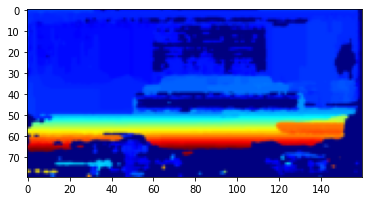

REAL tensor([3])


In [ ]:
label,input=next(iter(testloader))
outputs=model(input.to(device))
print("OUTPUTS",outputs)
outputs_=outputs.argmax(-1).cpu().detach()
print("PRED",outputs_)

image = to_pil(input[0])
print(image.size)
plt.imshow(image)
plt.show()

print("REAL",label)

In [ ]:

fgg=f"model_final.pth"
namesve = prefix_models+fgg
torch.save(model,namesve) 


In [ ]:
for mode, inputs in testloader:
    labels=mode.long()
    labels=F.one_hot(labels,num_classes=nclasses)

    optimizer.zero_grad()
    
    inputs,labels = inputs.to(device),labels.to(device)
    outputs=model(inputs)
    print(outputs)
    #outputs = mSig  (outputs)
    #outputs=torch.clamp(outputs, min=0, max=1.)
    
    #print ("Outputs shape: ", outputs.shape)
    
    loss = criterion(outputs.float(), labels.float() )
    pred_mode=outputs.argmax(-1).cpu().detach().numpy()
    real_mode=labels.argmax(-1).cpu().detach().numpy()
    print("Pred:",pred_mode," Real:",real_mode)

tensor([0.0033, 0.1336, 0.1091, 0.7515, 0.0024], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Pred: 3  Real: [3]
tensor([0.0084, 0.1510, 0.1721, 0.6589, 0.0096], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
Pred: 3  Real: [2]
tensor([0.0100, 0.0676, 0.3381, 0.5777, 0.0067], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
Pred: 3  Real: [3]
tensor([0.0090, 0.4789, 0.1286, 0.3626, 0.0209], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
Pred: 1  Real: [3]
tensor([0.0572, 0.3202, 0.2254, 0.3849, 0.0123], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
Pred: 3  Real: [2]
tensor([0.0032, 0.5422, 0.0245, 0.4207, 0.0094], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
Pred: 1  Real: [1]
tensor([0.2665, 0.2894, 0.1912, 0.1894, 0.0635], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
Pred: 1  Real: [1]
tensor([0.0147, 0.1988, 0.1362, 0.6358, 0.0145], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
Pred: 3  Real: [3]
tensor([0.0575, 0.5445, 0.0129, 0.1587, 0.2264], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
Pred: 1  Real: [1]
tensor([0.0224, 0.269